In [0]:
from __future__ import absolute_import, division, print_function, unicode_literals
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.layers import Dense, Conv2D, Flatten, Dropout, MaxPooling2D, Input, BatchNormalization, Dropout
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.preprocessing import image
from tensorflow.keras.utils import Sequence
from PIL import Image
import math
import os
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import classification_report, confusion_matrix
import seaborn as sns

# Dataset Directory & Data loader Implementation

dataset/  
├── train  
&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;├──cat -- 8500장  
&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;└──dog -- 8500장  
├── val  
&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;├──cat -- 2000장  
&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;└──dog -- 2000장  
└── test  
&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;├──cat -- 2000장  
&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;└──dog -- 2000장  

In [0]:
# 데이터 확인 함수
def check_images(train_path, val_path, test_path):
  train_cat_path = os.path.join(train_path,"cat")
  train_dog_path = os.path.join(train_path,"dog")
  val_cat_path = os.path.join(val_path,"cat")
  val_dog_path = os.path.join(val_path,"dog")
  test_cat_path = os.path.join(test_path,"cat")
  test_dog_path = os.path.join(test_path,"dog")

  num_cats_tr = len(os.listdir(train_cat_path))
  num_dogs_tr = len(os.listdir(train_dog_path))
  num_cats_val = len(os.listdir(val_cat_path))
  num_dogs_val = len(os.listdir(val_dog_path))
  num_cats_test = len(os.listdir(test_cat_path))
  num_dogs_test = len(os.listdir(test_dog_path))
  label = ['train', 'valid','test']
  cat = [num_cats_tr,num_cats_val,num_cats_test]
  dog = [num_dogs_tr,num_dogs_val,num_dogs_test]

  plt.rcParams["font.size"] = 12

  plt.figure(figsize=(12,8))

  x = np.arange(len(label))

  plt.bar(x-0.15, cat, label='cat', width=0.3, color='#FF0000')
  plt.bar(x+0.15, dog, label='dog', width=0.3, color='#0000FF')
  plt.legend()
  plt.xticks(x, label)
  plt.ylabel('Number of data')
  plt.title('Compare DATASETS')

  plt.show()
  return

In [0]:
# 데이터 로더 동작 확인
def data_info_print(data_gen, idx):
  batch = data_gen.__getitem__(idx)
  print(type(batch), type(batch[0]), type(batch[1]))
  # 변경
  print(len(batch[0]), len(batch[1]))
  plt.figure(figsize=(20,8))
  for i in range(len(batch[0])):
    plt.subplot(2,5,i+1)
    # 변경 
    plt.imshow(batch[0][i])
    
  print('label :', batch[1])
  print(type(batch[0][0]), type(batch[1][0]))

In [0]:
class Augment:
  # rotation
  def __init__(self, rotation, flip_left_right, flip_up_down, color, zoom):
    self.rotation = rotation
    self.flip_left_right = flip_left_right
    self.flip_up_down = flip_up_down
    self.color = color
    self.zoom = zoom

  def augmentation(self, img, size):
    if self.rotation:
      img=tf.image.rot90(img, tf.random.uniform(shape=[], minval=0, maxval=4, dtype=tf.int32))
    # flip_left_right
    if self.flip_left_right:
      img = tf.image.flip_left_right(image=img)

    # flip_up_down
    if self.flip_up_down:
      img = tf.image.flip_up_down(image=img)

    # color augmentation
    if self.color:
      img = tf.image.random_hue(image=img, max_delta = 0.4)
      img = tf.image.random_contrast(image=img,lower=0.7,upper=1.3)
      img = tf.image.random_saturation(image=img, lower=0.6, upper=1.6)
      img = tf.image.random_brightness(image=img, max_delta=0.05)

    # zoom
    if self.zoom:
      scales = list(np.arange(0.8, 1.0, 0.01))
      boxes = np.zeros((len(scales), 4))
      for i, scale in enumerate(scales):
          x1 = y1 = 0.5 - (0.5 * scale)
          x2 = y2 = 0.5 + (0.5 * scale)
          boxes[i] = [x1, y1, x2, y2]
      img = tf.image.crop_and_resize([img], boxes=boxes, box_indices=np.zeros(len(scales)), crop_size=(224, 224))
      choice = tf.random.uniform(shape=[], minval=0, maxval=19, dtype=tf.int64)
      return img[choice]
    return img

In [0]:
class Dataset_file_ver:
    def __init__(self, augment = None, path='./', target_size=(224,224)):
      self.dir_path = path
      self.target_size = target_size
      self.Image_list = []
      self.Image_label = []
      self.augment = augment
      for index in range(len(os.listdir(self.dir_path))):
          # 클래스 라벨 추가 (고양이 : 0. , 개 : 1.)
          self.label = 1.0
          if os.listdir(self.dir_path)[index].startswith('cat'):
              self.label = 0.0
          # 이미지 경로를 저장해 나중에 배치만큼만 이미지를 불러온다.
          self.Image_list.append(os.path.join(self.dir_path, os.listdir(self.dir_path)[index]))
          # 클래스 라벨은 이미지 경로 순서대로 넣어준다.
          self.Image_label.append(self.label)
      print('Found {} images'.format(len(self.Image_list)))
      
    def __len__(self):
      # 이미지 경로를 담은 리스트 전체를 리턴한다.
      return len(self.Image_list)

    def __getitem__(self, idx):
      # 호출 마다 한장의 이미지와 각 클래스 라벨을 같이 넘겨준다.
      img = image.load_img(self.Image_list[idx], target_size=self.target_size)
      img = image.img_to_array(img)
      img = img/255.0
      # image_augmentation
      if self.augment:
        img = self.augment.augmentation(img, self.target_size)
      #image = image.resize(self.target_size)
      return img, self.Image_label[idx]

In [0]:
class Dataset_dir_ver:
    def __init__(self, augment = None, path='./', target_size=(224,224)):
      self.dir_path = []
      self.target_size = target_size
      self.Image_list = []
      self.Image_label = []
      self.augment = augment

      for in_dir in os.listdir(path):
        self.dir_path.append(os.path.join(path,in_dir))

      for i in range(len(self.dir_path)):
        for index in range(len(os.listdir(self.dir_path[i]))):
            # 클래스 라벨 추가 (고양이 : 0. , 개 : 1.)
            self.label = 1.0
            if os.listdir(self.dir_path[i])[index].startswith('cat'):
                self.label = 0.0
            # 이미지 경로를 저장해 나중에 배치만큼만 이미지를 불러온다.
            self.Image_list.append(os.path.join(self.dir_path[i], os.listdir(self.dir_path[i])[index]))
            # 클래스 라벨은 이미지 경로 순서대로 넣어준다.
            self.Image_label.append(self.label)
      print('Found {} images'.format(len(self.Image_list)))

    def __len__(self):
      # 이미지 경로를 담은 리스트 전체를 리턴한다.
      return len(self.Image_list)

    def __getitem__(self, idx):
      # 호출 마다 한장의 이미지와 각 클래스 라벨을 같이 넘겨준다.
      img = image.load_img(self.Image_list[idx], target_size=self.target_size)
      img = image.img_to_array(img)
      img = img/255.0
      # image_augmentation
      if self.augment:
        img = self.augment.augmentation(img, self.target_size)
      #image = image.resize(self.target_size)
      # 변경
      return img, self.Image_label[idx]

In [0]:
class Data_Loader(Sequence):

    def __init__(self, dataset, batch_size=None, shuffle=False):
      # 데이터셋을 맴버로 가지며 데이터셋을 호출해 배치만큼 사진을 가지고 온다.
      self.dataset = dataset
      self.batch_size = batch_size
      self.shuffle=shuffle
      self.index_list = [idx for idx in range(len(self.dataset))]
      self.idx=0
    def __getitem__(self, idx):
      # 시작과 끝 인덱스 지정 --> 배치 사이즈만큼 for 루프를 실행하며 사진을 넘파이 배열에 저장한다.
      start = idx * self.batch_size
      end = (idx+1) * self.batch_size
      data = []
      label = []
      if self.shuffle:
        np.random.shuffle(self.index_list)
      # 변경
      # 배치사이즈 만큼 사진과 라벨을 리스트에 저장한다.
      for j in range(start,end):
        if j >= len(self.index_list):
          j%=len(self.dataset)
        data.append(self.dataset[self.index_list[j]])
      # 사진은 사진끼리 라벨은 라벨끼리 묶어서 리턴한다.
      #batch = tuple(sample for sample in zip(*data))
      batch = tuple(tf.stack(sample, axis=0) for sample in zip(*data))

      if self.idx >= (len(self.dataset)//self.batch_size):
        self.idx=0
      self.idx +=1
      return batch

    def __call__(self):
      batch = self.__getitem__(self.idx)
      return batch

    def __len__(self):
      # 데이터셋을 크기를 배치 사이즈로 나누어 준다.
        return (len(self.dataset) // self.batch_size)

    def get_batch(self):
      return self.batch_size

# Custom VGG16 Model Implementation

*   VGG16모델을 Conv_block과 Dense_block으로 나누어 각각 클래스화 시킨후 VGG16모델을 최종적으로 만드는 클래스에서 이 두 클래스를 호출하는 함수를 호출하는 방식으로 작성하였습니다. 



In [0]:
class Conv_block(tf.keras.layers.Layer):
  def __init__(self, filter_num, name, kernel_size  = (3,3), pool_size = (2,2), strides = (2,2)):
    super(Conv_block, self).__init__()
    self.filter_num = filter_num
    self.block_conv1 = Conv2D(self.filter_num, kernel_size, activation='relu', kernel_initializer='he_uniform', padding='same', name= name+'_conv1')
    self.block_conv2 = Conv2D(self.filter_num, kernel_size, activation='relu', kernel_initializer='he_uniform', padding='same', name= name+'_conv2')
    if self.filter_num >= 256:
      self.block_conv3 = Conv2D(self.filter_num, kernel_size, activation='relu', kernel_initializer='he_uniform', padding='same', name= name+'_conv3')
    self.block_batch = BatchNormalization()
    self.block_maxpool = MaxPooling2D(pool_size, strides=strides, name='block1_pool')

  def call(self, input_image, training = None):
    x = self.block_conv1(input_image)
    x = self.block_conv2(x)
    if self.filter_num>=256:
      x = self.block_conv3(x)
    x = self.block_batch(x, training=training)
    return self.block_maxpool(x)


In [0]:
class Dense_block(tf.keras.layers.Layer):
  def __init__(self, dense_units, out_num):
    super(Dense_block, self).__init__()
    self.flatten = Flatten()
    self.dense_1024 = Dense(dense_units[0], activation='relu', kernel_initializer='he_normal')
    self.dense_drop = Dropout(0.2)
    self.den_batch1 = BatchNormalization()
    self.dense_512 = Dense(dense_units[1], activation='relu', kernel_initializer='he_normal')
    self.den_batch2 = BatchNormalization()
    self.dense_output = Dense(out_num, activation='sigmoid')

  def call(self, input_image, training = None):
    x = self.flatten(input_image)
    x = self.dense_1024(x)
    x = self.dense_drop(x, training=training)
    x = self.den_batch1(x, training=training)
    x = self.dense_512(x)
    x = self.den_batch2(x, training=training)
    return self.dense_output(x)

In [0]:
def make_Conv_block(filter_num, name):
  block = tf.keras.Sequential()
  block.add(Conv_block(filter_num, name))
  return block

In [0]:
def make_Dense_block(Dense_units, out_num):
  block = tf.keras.Sequential()
  block.add(Dense_block(Dense_units, out_num))
  return block

In [0]:
class custom_vgg16(tf.keras.Model):
  def __init__(self):
    super(custom_vgg16, self).__init__()
    self.conv_block1 = make_Conv_block(64, 'block1')
    self.conv_block2 = make_Conv_block(128, 'block2')
    self.conv_block3 = make_Conv_block(256, 'block3')
    self.conv_block4 = make_Conv_block(512, 'block4')
    self.conv_block5 = make_Conv_block(512, 'block5')
    self.dense_block = make_Dense_block([1024, 512], 1)

  def call(self, input_image, training = None):
    x = self.conv_block1(input_image, training=training)
    x = self.conv_block2(x, training=training)
    x = self.conv_block3(x, training=training)
    x = self.conv_block4(x, training=training)
    x = self.conv_block5(x, training=training)
    return self.dense_block(x, training=training)

# 데이터 확인 & 데이터 로더 생성
* 각각 10장(고양이 5장, 개 5장)을 가지고 있는 디렉토리이며 겹치는 사진은 없습니다.


In [0]:
train_PATH = '/content/gdrive/My Drive/dataset/cat_vs_dog/train'
val_PATH = '/content/gdrive/My Drive/dataset/cat_vs_dog/val'
test_PATH = '/content/gdrive/My Drive/dataset/cat_vs_dog/test'

train_batch = 10
val_batch = 10
test_batch = 10
IMG_HEIGHT = 224
IMG_WIDTH = 224
IMG_CHANNELS = 3

aug_dic = dict(rotation=True,
               flip_left_right = False,
               flip_up_down = True,
               color = False,
               zoom = True)

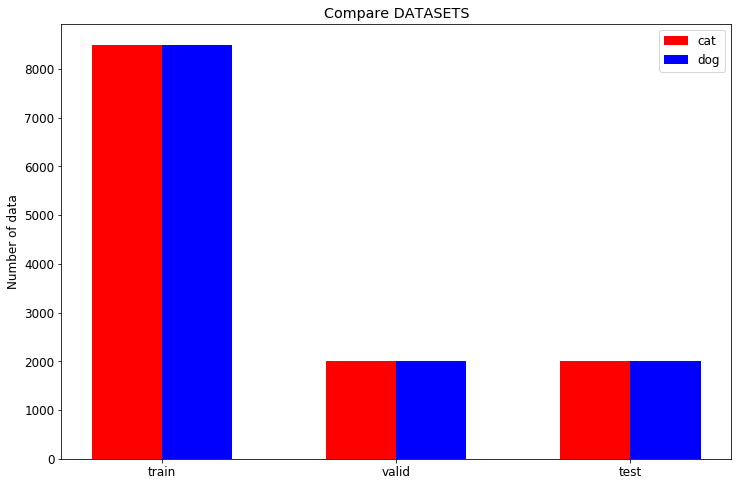

In [0]:
# 데이터 확인
check_images(train_path=train_PATH, val_path=val_PATH, test_path=test_PATH)

In [0]:
train_augment = Augment(**aug_dic)
train_dataset = Dataset_dir_ver(augment = train_augment, path=train_PATH)
train_data_gen = Data_Loader(dataset=train_dataset, batch_size=train_batch, shuffle=True)

Found 17000 images


In [0]:
val_dataset = Dataset_dir_ver(path=val_PATH)
val_data_gen = Data_Loader(dataset=val_dataset, batch_size=test_batch,shuffle=True)

Found 4000 images


In [0]:
test_dataset = Dataset_dir_ver(path=test_PATH)
test_data_gen = Data_Loader(dataset=test_dataset, batch_size=test_batch)

Found 4000 images


# train, val, test 데이터 로더의 출력 값과 형태, 타입, 갯수(배치 사이즈) augmentation된 사진 확인

<class 'tuple'> <class 'tensorflow.python.framework.ops.EagerTensor'> <class 'tensorflow.python.framework.ops.EagerTensor'>
10 10
label : tf.Tensor([0. 0. 0. 1. 0. 0. 0. 0. 1. 0.], shape=(10,), dtype=float32)
<class 'tensorflow.python.framework.ops.EagerTensor'> <class 'tensorflow.python.framework.ops.EagerTensor'>


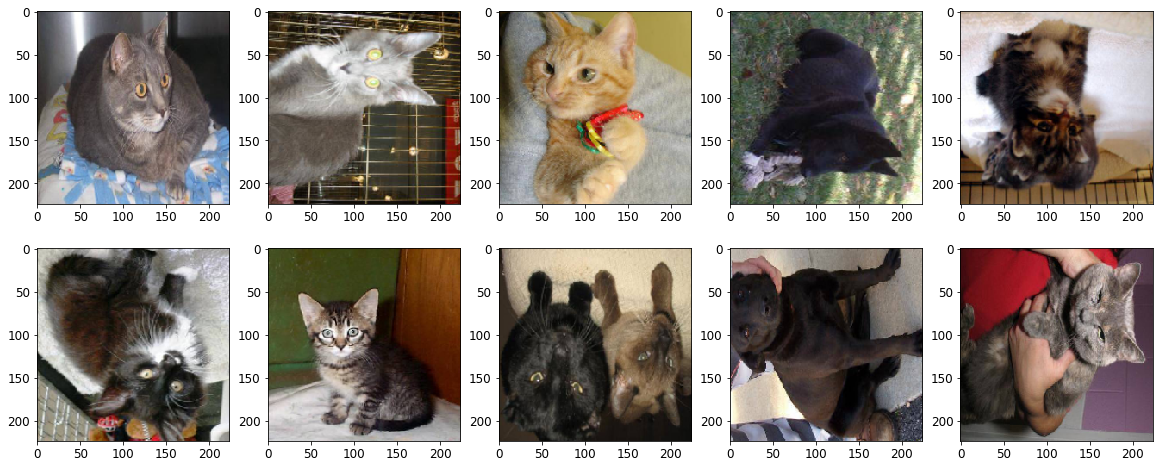

In [0]:
data_info_print(train_data_gen,0)

<class 'tuple'> <class 'tensorflow.python.framework.ops.EagerTensor'> <class 'tensorflow.python.framework.ops.EagerTensor'>
10 10
label : tf.Tensor([0. 1. 0. 1. 0. 1. 1. 1. 0. 1.], shape=(10,), dtype=float32)
<class 'tensorflow.python.framework.ops.EagerTensor'> <class 'tensorflow.python.framework.ops.EagerTensor'>


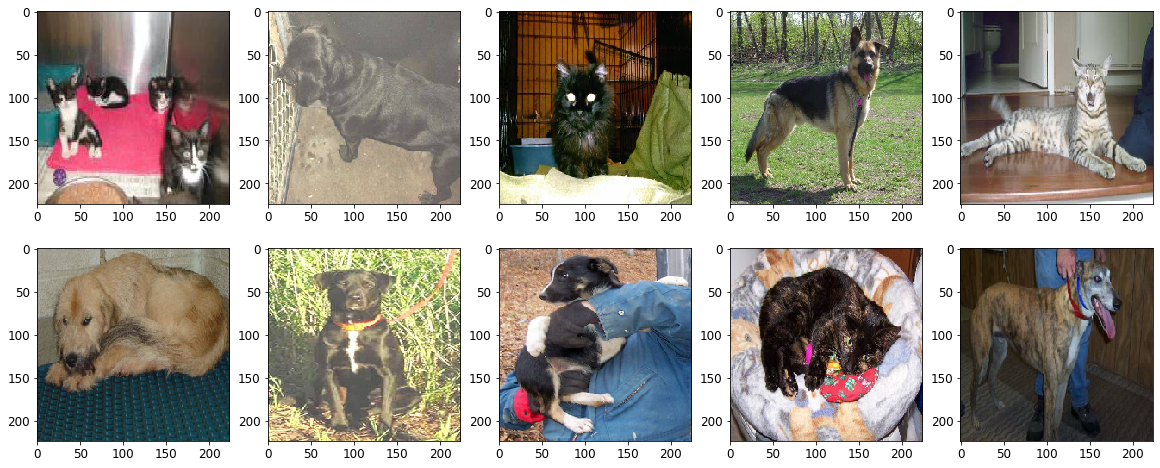

In [0]:
data_info_print(val_data_gen, 399)

<class 'tuple'> <class 'tensorflow.python.framework.ops.EagerTensor'> <class 'tensorflow.python.framework.ops.EagerTensor'>
10 10
label : tf.Tensor([0. 0. 0. 0. 0. 0. 0. 0. 0. 0.], shape=(10,), dtype=float32)
<class 'tensorflow.python.framework.ops.EagerTensor'> <class 'tensorflow.python.framework.ops.EagerTensor'>


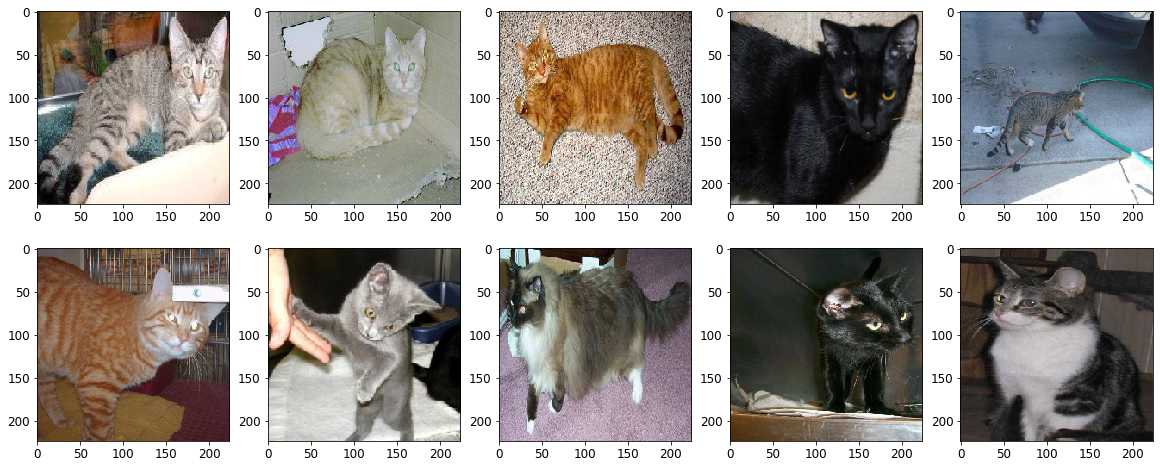

In [0]:
data_info_print(test_data_gen, 1)

# 모델 훈련  
### Using GradientTape


In [0]:
def fit_test(model, train_gen, train_steps, epochs, val_gen, val_steps):
  BATCH_SIZE = train_gen.get_batch()
  # define loss and optimizer
  optimizer = keras.optimizers.SGD(learning_rate=0.0001, momentum=0.9)
  loss_func = keras.losses.BinaryCrossentropy()

  train_loss = tf.keras.metrics.Mean(name='train_loss')
  train_accuracy = tf.keras.metrics.BinaryAccuracy(name='train_accuracy')

  valid_loss = tf.keras.metrics.Mean(name='valid_loss')
  valid_accuracy = tf.keras.metrics.BinaryAccuracy(name='valid_accuracy')


  train_losses = []
  train_acces = []
  val_losses = []
  val_acces = []


  @tf.function
  def train_step(images, labels):
      with tf.GradientTape() as tape:
          predictions = model(images, training=True)
          loss = loss_func(y_true=labels, y_pred=predictions)
      gradients = tape.gradient(loss, model.trainable_variables)
      optimizer.apply_gradients(grads_and_vars=zip(gradients, model.trainable_variables))

      train_loss(loss)
      train_accuracy(labels, predictions)

  @tf.function
  def valid_step(images, labels):

    predictions = model(images, training=False)
    v_loss = loss_func(labels, predictions)

    valid_loss(v_loss)
    valid_accuracy(labels, predictions)

  # start training
  for epoch in range(epochs):
      train_loss.reset_states()
      train_accuracy.reset_states()
      valid_loss.reset_states()
      valid_accuracy.reset_states()
      #step = 0
      for step in range(train_steps):
        print('.',end='')
        if step % 100 == 0:
          print()
        images, labels = train_data_gen()
        train_step(images, labels)
      print('x')
      for val_step in range(val_steps):
        print('.', end='')
        if val_step % 100 == 0:
          print()
        valid_images, valid_labels = val_data_gen()
        valid_step(valid_images, valid_labels)
      print('x')
      print("Epoch: {}/{}, train loss: {:.5f}, train accuracy: {:.5f}, "
            "valid loss: {:.5f}, valid accuracy: {:.5f}".format(epoch + 1,
                                                                epochs,
                                                                train_loss.result(),
                                                                train_accuracy.result(),
                                                                valid_loss.result(),
                                                                valid_accuracy.result()))
      train_losses.append(train_loss.result())
      train_acces.append(train_accuracy.result())
      val_losses.append(valid_loss.result())
      val_acces.append(valid_accuracy.result())

  history = {'train_losses': train_losses, 'train_acces': train_acces, 'val_losses': val_losses, 'val_acces': val_acces}
  return history

In [0]:
 def test_eval(model, test_data_gen, test_steps):
  loss_func = keras.losses.BinaryCrossentropy()
  test_loss = tf.keras.metrics.Mean()
  test_accuracy = tf.keras.metrics.BinaryAccuracy()

  @tf.function
  def test_step(images, labels):
      predictions = model(images, training=False)
      t_loss = loss_func(labels, predictions)

      test_loss(t_loss)
      test_accuracy(labels, predictions)

  for step in range(test_steps):
    print('.',end='')
    if step % 100 == 0:
      print()
    test_images, test_labels = test_data_gen()
    test_step(test_images, test_labels)
  print('x')
  print("loss: {:.5f}, test accuracy: {:.5f}".format(test_loss.result(),
                                                      test_accuracy.result()))

  #print("The accuracy on test set is: {:.3f}%".format(test_accuracy.result()*100))

In [0]:
train_step = 80
val_step = 20
epoch = 100
history = {}

In [0]:
model_vgg16 = custom_vgg16()

In [0]:
model_vgg16.load_weights(filepath='/content/gdrive/My Drive/save_model/vgg/use_custom/vgg_model_1360')

In [0]:
model_vgg16.build(input_shape=(None, IMG_HEIGHT, IMG_WIDTH, IMG_CHANNELS))

In [0]:
model_vgg16.summary()

Model: "custom_vgg16_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
sequential_6 (Sequential)    multiple                  38976     
_________________________________________________________________
sequential_7 (Sequential)    multiple                  221952    
_________________________________________________________________
sequential_8 (Sequential)    multiple                  1476352   
_________________________________________________________________
sequential_9 (Sequential)    multiple                  5901824   
_________________________________________________________________
sequential_10 (Sequential)   multiple                  7081472   
_________________________________________________________________
sequential_11 (Sequential)   multiple                  26222593  
Total params: 40,943,169
Trainable params: 40,937,153
Non-trainable params: 6,016
____________________________________

In [0]:
history = fit_test(model=model_vgg16, train_gen=train_data_gen, train_steps=train_step, epochs=epoch, val_gen=val_data_gen, val_steps=val_step)

.
Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where
...............................................................................x
.
...................x
Epoch: 1/100, train loss: 0.46353, train accuracy: 0.78500, valid loss: 0.40299, valid accuracy: 0.82000
.
...............................................................................x
.
...................x
Epoch: 2/100, train loss: 0.54662, train accuracy: 0.74750, valid loss: 0.40279, valid accuracy: 0.82000
.
...............................................................................x
.
...................x
Epoch: 3/100, train loss: 0.52132, train accuracy: 0.73250, valid loss: 0.35660, valid accuracy: 0.88000
.
...............................................................................x
.
...................x
Epoch: 4/100, train loss: 0.50531, train accuracy: 0.73000, valid loss: 0.39892, valid accuracy: 0.81000
.
............................................................

In [0]:
# 1440
history = fit_test(model=model_vgg16, train_gen=train_data_gen, train_steps=train_step, epochs=20, val_gen=val_data_gen, val_steps=val_step)

.
...............................................................................x
.
...................x
Epoch: 1/20, train loss: 0.25714, train accuracy: 0.88625, valid loss: 0.19757, valid accuracy: 0.92000
.
...............................................................................x
.
...................x
Epoch: 2/20, train loss: 0.23818, train accuracy: 0.90250, valid loss: 0.21049, valid accuracy: 0.93500
.
...............................................................................x
.
...................x
Epoch: 3/20, train loss: 0.25634, train accuracy: 0.90375, valid loss: 0.10421, valid accuracy: 0.96000
.
...............................................................................x
.
...................x
Epoch: 4/20, train loss: 0.23443, train accuracy: 0.90125, valid loss: 0.18063, valid accuracy: 0.95000
.
...............................................................................x
.
...................x
Epoch: 5/20, train loss: 0.26396, train accuracy: 0.89

In [0]:
# 1360
test_eval(model_vgg16, test_data_gen, 400)

.
....................................................................................................
....................................................................................................
....................................................................................................
...................................................................................................x
loss: 0.24069, test accuracy: 0.90325


# 저장

In [0]:
model_vgg16.save_weights('/content/gdrive/My Drive/save_model/vgg/use_custom/vgg_model_1360', save_format='tf')

# model test


In [0]:
def his_graph(history, epoch):
  acc = history['train_acces']
  val_acc = history['val_acces']

  loss = history['train_losses']
  val_loss = history['val_losses']

  epochs_range = range(epoch)

  plt.figure(figsize=(8, 8))
  plt.subplot(2, 1, 1)
  plt.plot(epochs_range, acc, label='Training Accuracy')
  plt.plot(epochs_range, val_acc, label='Validation Accuracy')
  plt.legend(loc='lower right')
  plt.title('Training and Validation Accuracy')

  plt.subplot(2, 1, 2)
  plt.plot(epochs_range, loss, label='Training Loss')
  plt.plot(epochs_range, val_loss, label='Validation Loss')
  plt.legend(loc='upper right')
  plt.title('Training and Validation Loss')

  plt.show()

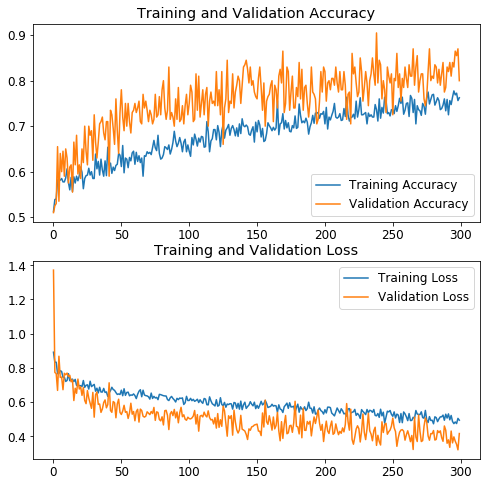

In [0]:
his_graph(total_history,total_epochs)

In [0]:
def model_predict(model, test_gen, steps):
  predics=[]
  labels = []
  for step in range(steps):
    image,label = test_gen()
    pred = model(image)
    labels.append(label)
    predics.append(pred)
  re_dic = dict({'pred':predics, 'labels':labels})
  return re_dic

In [0]:
pred_dataset = Dataset_dir_ver(path=test_PATH)
pred_data_gen = Data_Loader(dataset=test_dataset, batch_size=1)

Found 4000 images


In [0]:
def pred_confusion_matrix(pred, labels):
  pred_int = []
  for i in range(len(pred)):
    if pred[i] > 0.5:
      pred_int.append(1)
    elif pred[i] <= 0.5:
      pred_int.append(0)

  print(len(pred))
  print(len(pred_int))
  print('Confusion Matrix')
  conf_matrix = confusion_matrix(labels, pred_int)
  print(conf_matrix)
  sns.heatmap(conf_matrix,cmap="Blues",annot=True,fmt='g');
  plt.xlabel('predicted value')
  plt.ylabel('true value');

In [0]:
re_dic = model_predict(model_vgg16, pred_data_gen, 4000)
pred = re_dic['pred']
labels = re_dic['labels']
pred = list(map(float,pred))

4000
4000
Confusion Matrix
[[1795  205]
 [ 182 1818]]


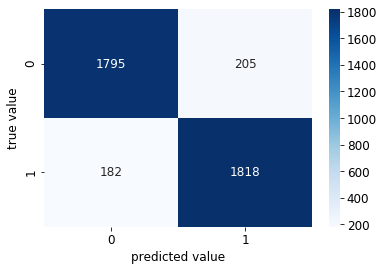

In [0]:
pred_confusion_matrix(pred, labels)